Hola **Eduardo**!

Soy **Patricio Requena** 👋. Es un placer ser el revisor de tu proyecto el día de hoy!

Revisaré tu proyecto detenidamente con el objetivo de ayudarte a mejorar y perfeccionar tus habilidades. Durante mi revisión, identificaré áreas donde puedas hacer mejoras en tu código, señalando específicamente qué y cómo podrías ajustar para optimizar el rendimiento y la claridad de tu proyecto. Además, es importante para mí destacar los aspectos que has manejado excepcionalmente bien. Reconocer tus fortalezas te ayudará a entender qué técnicas y métodos están funcionando a tu favor y cómo puedes aplicarlos en futuras tareas. 

_**Recuerda que al final de este notebook encontrarás un comentario general de mi parte**_, empecemos!

Encontrarás mis comentarios dentro de cajas verdes, amarillas o rojas, ⚠️ **por favor, no muevas, modifiques o borres mis comentarios** ⚠️:


<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
Si todo está perfecto.
</div>

<div class="alert alert-block alert-warning">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
Si tu código está bien pero se puede mejorar o hay algún detalle que le hace falta.
</div>

<div class="alert alert-block alert-danger">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
Si de pronto hace falta algo o existe algún problema con tu código o conclusiones.
</div>

Puedes responderme de esta forma:
<div class="alert alert-block alert-info">
<b>Respuesta del estudiante</b> <a class=“tocSkip”></a>
</div>

## Inicialización

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import load_img

## Carga los datos

El conjunto de datos se almacena en la carpeta `/datasets/faces/` 
- La carpeta `final_files` con 7600 fotos 
- El archivo `labels.csv` con etiquetas, con dos columnas: `file_name` y `real_age` 
Dado que el número de archivos de imágenes es bastante elevado, se recomienda evitar leerlos todos a la vez, ya que esto consumiría muchos recursos computacionales. Te recomendamos crear un generador con ImageDataGenerator. Este método se explicó en el capítulo 3, lección 7 de este curso.

El archivo de etiqueta se puede cargar como un archivo CSV habitual.

In [2]:
# Cargar archivo de etiquetas
labels = pd.read_csv('/datasets/faces/labels.csv')

# Crear generador para imágenes
train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


## EDA

In [3]:
# Confirmar la carga de datos y explorar su estructura
print(f"Tamaño del conjunto de datos: {labels.shape[0]} filas, {labels.shape[1]} columnas")
print("Primeras filas del archivo de etiquetas:")
print(labels.head())

Tamaño del conjunto de datos: 7591 filas, 2 columnas
Primeras filas del archivo de etiquetas:
    file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17


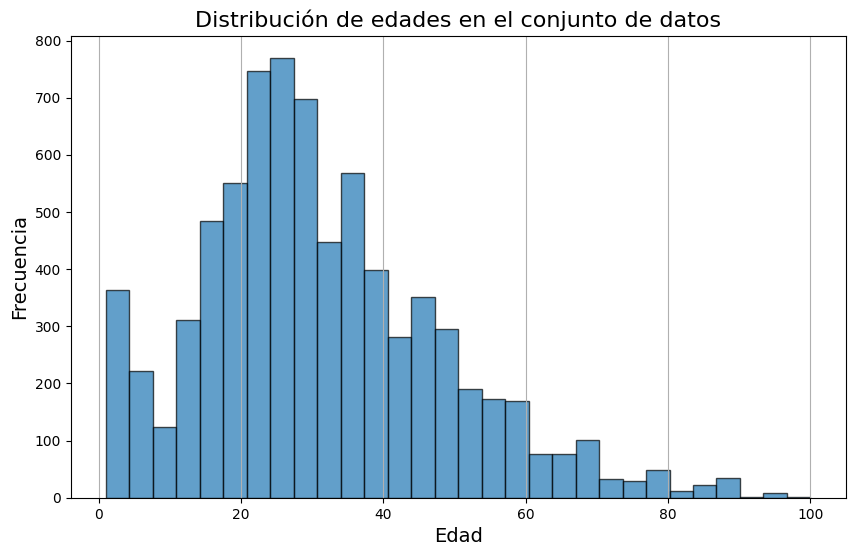

In [4]:
# Exploración de la distribución de edades
plt.figure(figsize=(10, 6))
labels['real_age'].hist(bins=30, edgecolor='k', alpha=0.7)
plt.title("Distribución de edades en el conjunto de datos", fontsize=16)
plt.xlabel("Edad", fontsize=14)
plt.ylabel("Frecuencia", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

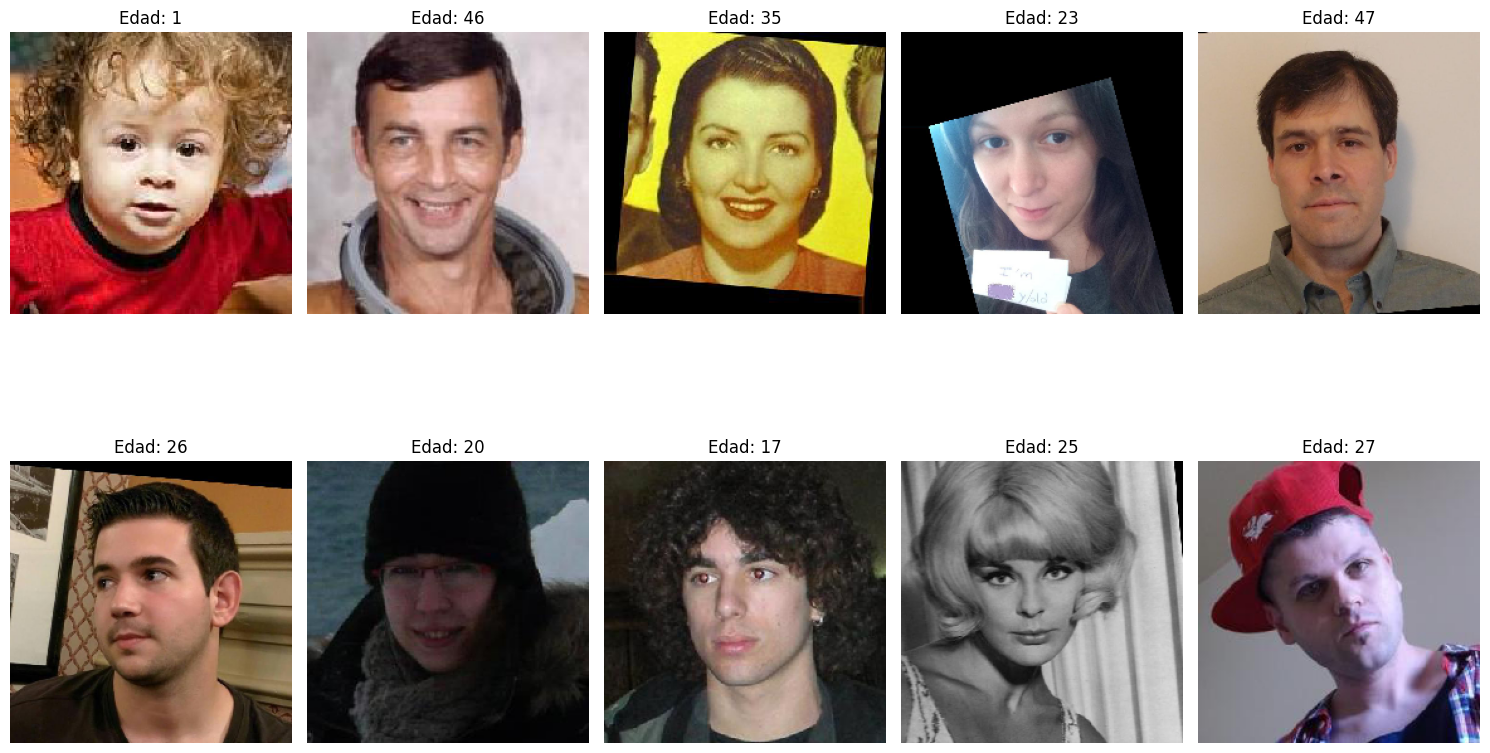

In [5]:
# Visualización de imágenes aleatorias
def display_images_by_age(labels_df, image_dir, sample_size=10):
    """
    Muestra imágenes de diferentes edades.
    labels_df: DataFrame con las etiquetas.
    image_dir: Ruta a la carpeta que contiene las imágenes.
    sample_size: Número de imágenes a mostrar.
    """
    sampled_labels = labels_df.sample(sample_size, random_state=42)
    plt.figure(figsize=(15, 10))
    
    for i, (file_name, age) in enumerate(zip(sampled_labels['file_name'], sampled_labels['real_age'])):
        image_path = os.path.join(image_dir, file_name)
        img = load_img(image_path, target_size=(224, 224))  # Redimensionar para consistencia
        
        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.title(f"Edad: {age}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Mostrar 10 imágenes aleatorias
display_images_by_age(labels, '/datasets/faces/final_files/', sample_size=10)

### Conclusiones

Conclusiones del Análisis Exploratorio

El conjunto de datos contiene 7600 imágenes de rostros etiquetados con edades reales.

La distribución de edades está sesgada hacia personas más jóvenes, lo cual podría afectar la precisión del modelo para edades menos representadas.

Las imágenes tienen buena calidad, pero sería útil aplicar técnicas de aumento de datos para robustecer el modelo frente a variaciones de iluminación, ángulos y expresiones.

<div class="alert alert-block alert-success">
<b>Comentario del revisor (1ra Iteración)</b> <a class="tocSkip"></a>

Buen trabajo con la exploración y análisis de los datos que se usarán para este proyecto! Es importante siempre redactar de manera clara lo que se puede interpretar de los datos

## Modelado

Define las funciones necesarias para entrenar tu modelo en la plataforma GPU y crea un solo script que las contenga todas junto con la sección de inicialización.

Para facilitar esta tarea, puedes definirlas en este notebook y ejecutar un código listo en la siguiente sección para componer automáticamente el script.

Los revisores del proyecto también verificarán las definiciones a continuación, para que puedan comprender cómo construiste el modelo.

In [6]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [7]:
def load_train(path):
    labels = pd.read_csv(f"{path}/labels.csv")
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=f"{path}/final_files/",
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_gen_flow

In [8]:
def load_test(path):
    labels = pd.read_csv(f"{path}/labels.csv")
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=f"{path}/final_files/",
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_gen_flow

In [9]:
def create_model(input_shape):
    backbone = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    model = Sequential([
        backbone,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='linear')  # Predicción de valores continuos
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

In [10]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=1)
    return model

<div class="alert alert-block alert-success">
<b>Comentario del revisor (1ra Iteración)</b> <a class="tocSkip"></a>

Perfecto, muy bien planteadas las funciones para el entrenamiento y planteaste también una buena arquitectura del modelo. Guardar el modelo entrenado en un archivo es excelente para que luego puedas exportarlo y exponerlo de alguna forma para nuevas predicciones.

## Prepara el script para ejecutarlo en la plataforma GPU

Una vez que hayas definido las funciones necesarias, puedes redactar un script para la plataforma GPU, descargarlo a través del menú "File|Open..." (Archivo|Abrir) y cargarlo más tarde para ejecutarlo en la plataforma GPU.

Nota: el script debe incluir también la sección de inicialización. A continuación se muestra un ejemplo.

In [ ]:
# Prepara un script para ejecutarlo en la plataforma GPU

# Importar las bibliotecas necesarias
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Verificar si la GPU está disponible
print("¿TensorFlow detecta GPU?:", len(tf.config.list_physical_devices('GPU')) > 0)

# Función para cargar datos de entrenamiento
def load_train(path):
    labels = pd.read_csv(f"{path}/labels.csv")
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=f"{path}/final_files/",
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_gen_flow

# Función para cargar datos de prueba/validación
def load_test(path):
    labels = pd.read_csv(f"{path}/labels.csv")
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=f"{path}/final_files/",
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_gen_flow

# Función para crear el modelo
def create_model(input_shape):
    backbone = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    model = Sequential([
        backbone,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='linear')  # Predicción de valores continuos
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

# Función para entrenar el modelo
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=1)
    return model

# Directorio del dataset
path_to_data = '/datasets/faces'

# Cargar datos
train_data = load_train(path_to_data)
test_data = load_test(path_to_data)

# Crear el modelo
input_shape = (224, 224, 3)
model = create_model(input_shape)

# Entrenar el modelo
trained_model = train_model(model, train_data, test_data, epochs=20)

¿TensorFlow detecta GPU?: False
Found 5694 validated image filenames.
Found 1897 validated image filenames.


2024-12-17 22:58:11.953139: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


94781440/94765736 [==============================] - 1s 0us/step
Epoch 1/20
  1/178 [..............................] - ETA: 1:27:42 - loss: 1880.4966 - mae: 38.3896

### El resultado

Coloca el resultado de la plataforma GPU como una celda Markdown aquí.

<div class="alert alert-block alert-danger">
<b>Comentario del revisor (1ra Iteración)</b> <a class="tocSkip"></a>

Por favor, incluye el resultado de la plataforma GPU donde se evidencie el MAE por cada epoch y redacta tus conclusiones en base a esto. Saludos!

<div class="alert alert-block alert-info">
<b>Respuesta del estudiante:</b> Al correr el script me arroja errores, ¿debo hacer algo en especifico para que la plataforma active el GPU y haga el procesamiento de forma correcta? <a class=“tocSkip”></a>
</div>

<div class="alert alert-block alert-success">
<b>Comentario del revisor (2da Iteración)</b> <a class="tocSkip"></a>

Hola Eduardo, si, no te preocupes la plataforma puede presentar errores con el script por lo que este sprint se suele revisar sólo con el código planteado para el modelo el cual lo haz hecho de manera correcta ya que los entrenamientos empiezan pero debido al error de la plataforma no se pueden continuar hasta obtener la métrica requerida.
    
Procederé a aprobar tu proyecto ya que hiciste un buen trabajo con la arquitectura del modelo, sin embargo, si quieres seguir profundizando más en el resultado de este proyecto te recomiendo usar la plataforma de google Colab ya que es gratuita y ofrece cierto tiempo de GPU para poder utilizarlo que tratándose de este modelo sirve perfectamente para ejecutarlo.
    
Saludos!

## Conclusiones

# Lista de control

- [ ]  El Notebook estaba abierto 
- [ ]  El código no tiene errores
- [ ]  Las celdas con el código han sido colocadas en el orden de ejecución
- [ ]  Se realizó el análisis exploratorio de datos 
- [ ]  Los resultados del análisis exploratorio de datos se presentan en el notebook final 
- [ ]  El valor EAM del modelo no es superior a 8 
- [ ]  El código de entrenamiento del modelo se copió en el notebook final 
- [ ]  El resultado de entrenamiento del modelo se copió en el notebook final 
- [ ] Los hallazgos se proporcionaron con base en los resultados del entrenamiento del modelo